In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from numpy.linalg import inv

In [221]:
def pourcentage(n_components,B,G):
    
    percents=[]
    numerators=[]
    
    denominator = np.zeros((B.shape[0],G.shape[1]))
    for i in range(n_components):
    
        denominator += np.matmul(B[:,i].reshape((B.shape[0],1)),G[i,:].reshape((1,G.shape[1])))
        numerator = np.matmul(B[:,i].reshape((B.shape[0],1)),G[i,:].reshape((1,G.shape[1])))
        numerators.append(numerator)

        
    for i in range(n_components):
        
        percents.append(numerators[i]/(denominator+0.001))
    
    return percents

In [227]:
samplerate, data = read("Music-summer.wav")
music=data[1000000:2000000,0]
length=music.shape[0]/samplerate
print('Shape of the data {}'.format(music.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate))

Shape of the data 1000000
Length : 22.68s
Sample rate : 44100


# Apply STFT :

## We can change :

* Window : Type of window
* nperseg : length of window
* noverlap : overlap between windows.
* nfft : fft length > window size

In [253]:
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.5 * WINDOW_SIZE
NFFT=512

In [254]:
f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs=np.abs(Y)

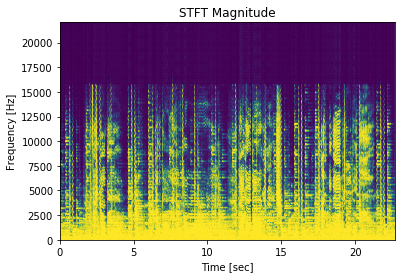

In [126]:
plt.pcolormesh(t, f, np.abs(Zxx),vmin=0, vmax=20, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [252]:
 _, xrec =  signal.istft(Y,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
write("Test_output/STFT.wav", samplerate, xrec.astype(np.int16))

# NMF:

In [255]:
n_components=2

In [256]:
model = NMF(n_components=n_components, init='random',alpha=0.5,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
B = model.fit_transform(Zxxabs)
G = model.components_

In [214]:
print('shape of bases : {}'.format(B.shape))
print('shape of wheights : {}'.format(G.shape))

shape of bases : (513, 2)
shape of wheights : (2, 10418)


# Estimation of the magnitude of the source 1:

In [257]:
percents = pourcentage(n_components,B,G)
Sources=[]

for i in range(n_components):
    
    Sources.append(np.multiply(percents[i],Zxx))

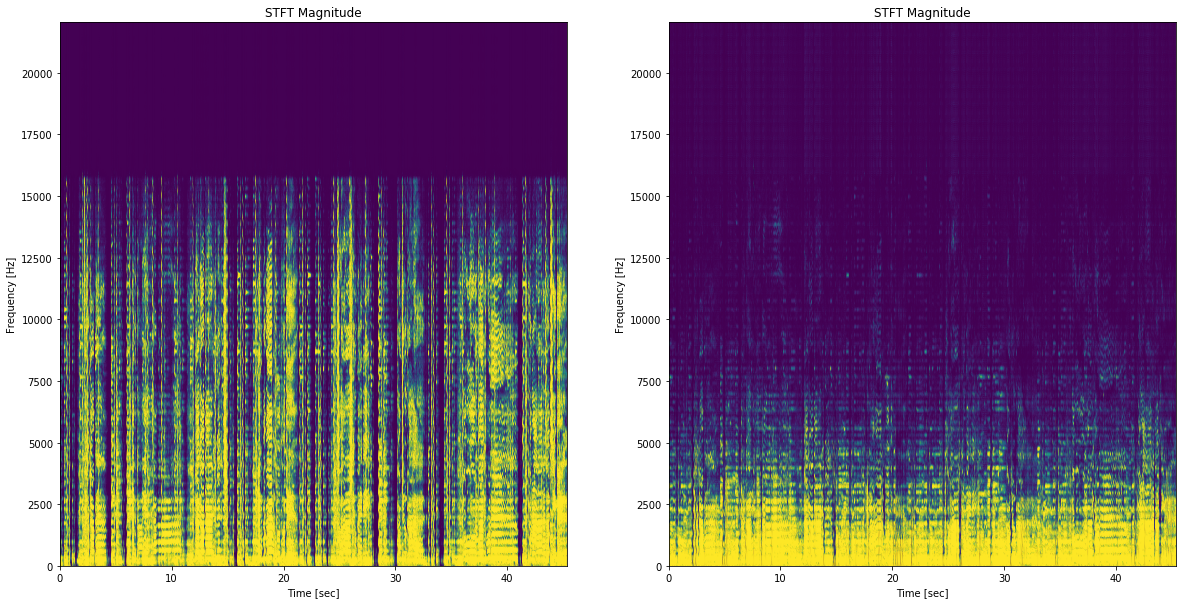

In [223]:
fig,ax=plt.subplots(1,n_components,figsize=(20,10))

for i in range(n_components):
        
        ax[i].pcolormesh(t, f,Sources[i],vmin=0, vmax=20, shading='gouraud')
        ax[i].set_title('STFT Magnitude')
        ax[i].set_ylabel('Frequency [Hz]')
        ax[i].set_xlabel('Time [sec]')

In [176]:
percents[0].mean()

0.5938672918847474

In [258]:
for i in range(n_components):
    
    _, xrec =  signal.istft(Sources[i],
                          samplerate,
                          window = "hamming",
                          nperseg=480,
                          noverlap=480*0.5,
                          nfft = 512)
    write("Test_output/example"+str(i)+".wav", samplerate, xrec.astype(np.int16))

# Test using different configs of NMF:

In [190]:
def itakura_saito(Y,B,G):
    
    reconstruction = np.matmul(B,G)
    div = Y / reconstruction
    cost = np.sum(div-np.log(div)) -np.product(Y.shape)
    return cost
            

In [201]:
costs=[]
inits=['random', 'nndsvda']
for init in inits:
    model = NMF(n_components=n_components, init=init,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
    B = model.fit_transform(Zxxabs)
    G = model.components_
    costs.append(itakura_saito(Zxxabs,B,G))

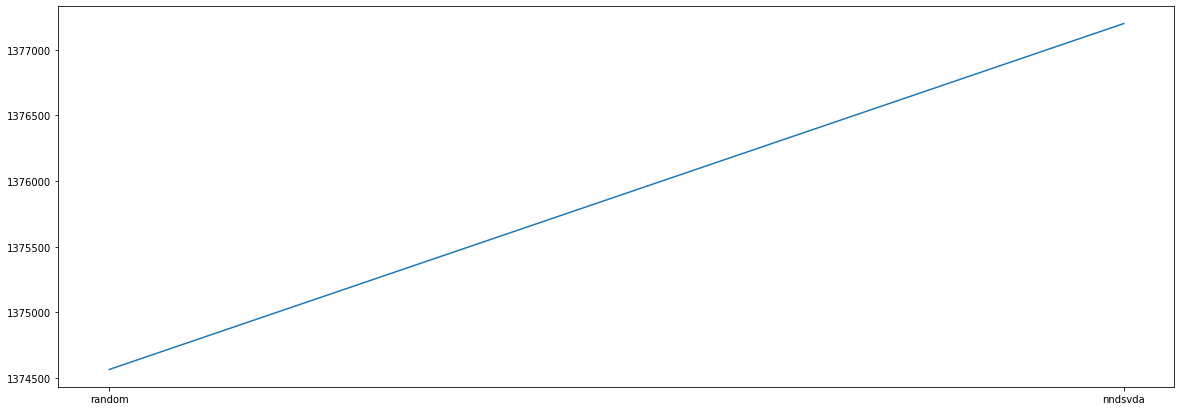

In [202]:
plt.figure(figsize=(20,7))
plt.plot(inits,costs)